# Training models with BioEngine

## Download a sample dataset with 4 images

In [25]:
try:
    # JupyterLite/Pyodide
    import pyodide
    import micropip
    await micropip.install('pyotritonclient')
    from imjoy_rpc.utils import open_elfinder
    IS_PYODIDE = True
except ImportError:
    IS_PYODIDE = False
    # For native python with pip
    import subprocess
    subprocess.call(['pip', 'install', 'pyotritonclient', 'imjoy-rpc', 'requests'])

import io
import asyncio
import os
from pyotritonclient import SequenceExcutor, execute
import numpy as np
import pickle
import imageio
from js import fetch
import matplotlib.pyplot as plt


%matplotlib inline

def display_image(image, mask):
    # display the output
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title('input image')
    ax2.imshow(mask)
    ax2.set_title('predicted mask')
    plt.show()

async def download_data(url):
    if IS_PYODIDE:
        response = await fetch(url)
        bytes = await response.arrayBuffer()
        bytes = bytes.to_py()
        buffer = io.BytesIO(bytes)
    else:
        import requests
        response = requests.get(url)
        buffer = io.BytesIO(response.content)
    return pickle.load(buffer)

async def train(model_id, samples, epochs=1, model_token = None, resume=True, pretrained_model="cyto", channels=None, diameter=100):
    """
    Train a cellpose model through the BioEngine
    # set pretrained_model to None if you want to train from scratch
    # set model_token to a string if you want to protect the model
    # from overwriting by other users
    """
    seq = SequenceExcutor(
        server_url="https://ai.imjoy.io/triton",
        model_name="cellpose-train",
        decode_json=True,
        sequence_id=model_id,
    )
    if not channels:
        channels = [1, 2]
    for epoch in range(epochs):
        losses = []
        for (image, labels, info) in samples:
            inputs = [
                image.astype("float32"),
                labels.astype("uint16"),
                {
                    "steps": 16,
                    "pretrained_model": pretrained_model,
                    "resume": resume,
                    "model_token": model_token,
                    "channels": channels,
                    "diam_mean": 30,
                },
            ]
            result = await seq.step(inputs, select_outputs=["info"])
            losses.append(result["info"][0]["loss"])
        avg_loss = np.array(losses).mean()
        print(f"Epoch {epoch}  loss={avg_loss}")
    await seq.end()

async def predict(model_id, samples, channels=None, diameter=100, reload=False):
    """Make predition with the specified cellpose model"""
    # Start the prediction
    seq = SequenceExcutor(
        server_url="https://ai.imjoy.io/triton",
        model_name="cellpose-predict",
        decode_json=True,
        sequence_id=model_id,
    )
    if not channels:
        channels = [1, 2]
    for i, (image, _, _) in enumerate(samples):
        inputs = [image.astype("float32"), {"channels": channels, "diameter": diameter, "reload": reload}]
        results = await seq.step(inputs, select_outputs=["mask"])
        display_image(image, results['mask'])
    # await seq.end()

async def download_model(model_id, valid_image, valid_labels, model_token = None):
    """
    Download the trained model by its id.
    """
    seq = SequenceExcutor(
        server_url="https://ai.imjoy.io/triton",
        model_name="cellpose-train",
        decode_json=True,
        sequence_id=model_id,
    )
    print(f"Exporting cellpose model: {model_id}")
    result = await seq.end(
        [
            valid_image.astype("float32"),
            valid_labels.astype("uint16"),
            {
                "resume": True,
                "model_token": model_token,
                "channels": [1, 2],
                "diameter": 100.0,
                "model_format": "bioimageio",
            },
        ],
        decode_json=True,
        select_outputs=["info", "model"],
    )
    # Save the weights
    model_package = result["model"][0]
    filename = result["info"][0]["model_files"][0]
    print(f"Saving model {filename}...")
    if IS_PYODIDE:
        with open_elfinder("/home/"+filename, "wb") as fil:
            fil.write(model_package)
    else:
        with open(os.path.join(os.path.expanduser('~'), filename), "wb") as fil:
            fil.write(model_package)
        
    print(f"Model package saved to {filename}")

Dataset downloaded 4 4
(512, 512, 3) (512, 512, 1)


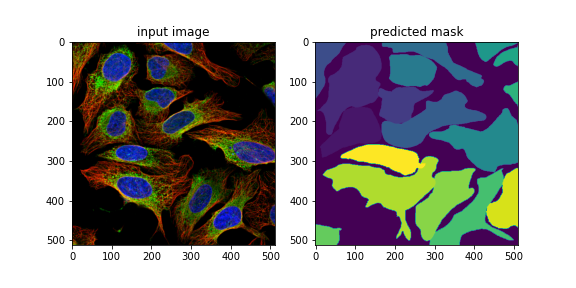

In [26]:
test_samples = await download_data("https://raw.githubusercontent.com/bioimage-io/BioEngine/main/notebooks/test_samples_4.pkl")
train_samples = await download_data("https://raw.githubusercontent.com/bioimage-io/BioEngine/main/notebooks/train_samples_4.pkl")
print("Dataset downloaded", len(train_samples), len(test_samples))

(image, labels, info) = train_samples[0]
print(image.shape, labels.shape)
display_image(image, labels)

## Train a cellpose model

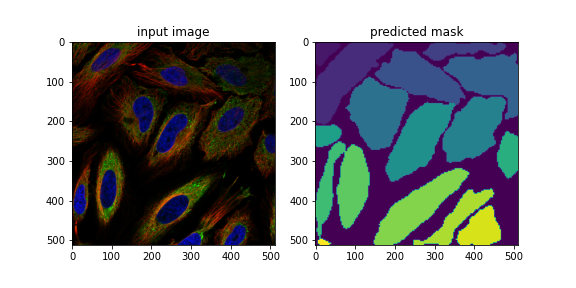

In [12]:
await train(model_id=106, samples=train_samples, epochs=10, resume=True, pretrained_model=None)
await predict(model_id=106, samples=test_samples[:1])

## Optionally, download the trained model

In [21]:
valid_image, valid_labels, _ = train_samples[0]
await download_model(model_id=106, valid_image=valid_image, valid_labels=valid_labels)

if IS_PYODIDE:
    from imjoy import api
    # Display the file browser, so you can download the model
    # by right click on the zip file and choose download
    async def setup():
        fm = await api.createWindow(
            src="https://jupyter.imjoy.io/elFinder/index.html"
        )

    api.export({"setup": setup})

Exporting cellpose model: 106
Saving model cellpose-bioimageio-106.zip...
Model package saved to cellpose-bioimageio-106.zip


<IPython.core.display.Javascript object>

# Use the trained model for prediction

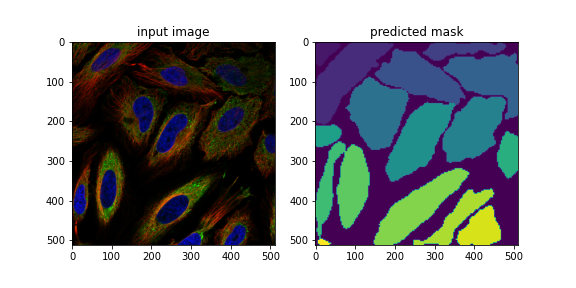

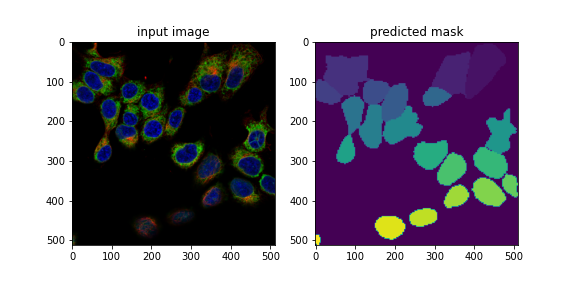

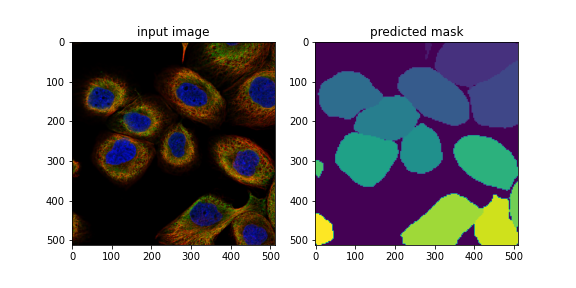

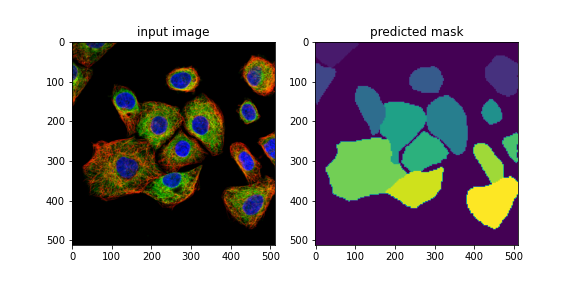

In [23]:
await predict(model_id=106, samples=test_samples)